# Part 1: Gradient Descent

In [2]:
import numpy as np # linear algebra
import pandas as pd #dataframe library
import sklearn # machine learning library
assert sklearn.__version__ >= '0.2'
from sklearn import datasets
import random
np.random.seed(seed=42) # to have same results each time
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Question 1: Load an original dataset, comment on this dataset (what are the features, the dimensions of the problem, how does the correlation matrix looks like)

First we import the dataset "California housing" retrieved from Scikit-learn, and take a brief look at the data before separating in two sets: a training and a test set.

The dataset is composed of 8 numeric features: 
- MedInc: median income in block group
- HouseAge: median house age in block group
- AveRooms: average number of rooms per household
- AveBedrms: average number of bedrooms per household
- Population: block group population
- AveOccup: average number of household members
- Latitude: block group latitude
- Longitude: block group longitude

And the target value, numeric as well:
- MedHouseVal: median house value expressed in $100,000.

In [3]:
#we use pandas for taking a first look at the data
dataset_panda = sklearn.datasets.fetch_california_housing(data_home=None, download_if_missing=True, return_X_y=False, as_frame=True)
dataset_panda['frame'].head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Dataset is composed of 20,640 entries and is compelete (non-missing values). As it only acconts for 1.4 MB, memory usage shouldn't be an issue.

In [4]:
dataset_panda['frame'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


The matrix is symetric as expected, with 1 on the diagonal.  It appears MedHouseVal is mosty correlated with MedInc in a positive manner, so this feature should play the most important role in prediction. The higher MedInc the higher MedHouseVal on the whole dataset.

In [5]:
corr_matrix = dataset_panda['frame'].corr()
corr_matrix


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
MedHouseVal,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


### Question 2: Implement gradient descent for regression (l2 loss) or classification (logistic loss) with a small ridge penalty. Display the convergence rate on the training loss for several fixed step sizes. 

Now let's switch to numpy for our numerical analysis.

In [6]:
dataset = sklearn.datasets.fetch_california_housing(data_home=None, download_if_missing=True, return_X_y=False, as_frame=False)
A = dataset['data']
Y = dataset['target']

In [7]:
def unison_shuffled_copies(a, b):
    '''
    Returns a similar permutation between arrays a,b
    '''
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

A_shuffled, Y_shuffled = unison_shuffled_copies(A, Y)

In [8]:
TRAINING_RATIO = 0.75

N = len(Y_shuffled) #numbers of rows
D = len(A_shuffled[0,:]) #number of features
N_TRAIN = int(TRAINING_RATIO*N) # number of rows in the training set
N_TEST = N - N_TRAIN # number of rows in the test set

A_train = A_shuffled[:N_TRAIN,:]
Y_train = Y_shuffled[:N_TRAIN]

A_test = A_shuffled[N_TRAIN:,:]
Y_test = Y_shuffled[N_TRAIN:]

#we will normalize our data as well to better performance (less anisotropy, so the Gradient descent sould be faster)
mean = A_train.mean(axis=0)
std = A_train.std(axis=0)
A_train = (A_train-mean)/std


Now we can implement the linear regression model. As N>>D, the model is overdetermined so we are sure to find a solution using Gradient Descent. In fact, here we use a regularized ridge model so our function to minimize will be strictly convex and we have a unique solution: we will reach it using GD and compare it with the closed form solution.

Regularization is obtained by introducing a penalty. It is often called ridge regression, and is defined as $$ \min_{x} \lVert Ax-y \rVert  ^2+\lambda \lVert x \rVert^2$$ with $\lambda$ > 0 the regularization parameter.

The solution is given using the following equivalent formula $$ x = (A^\top A + \lambda \text{Id}_p )^{-1} A^\top y $$ 


In [9]:
def gradient_descent(nb_of_iterations, step_size, ridge_parameter, add_bias):
    '''
    Perform GD on the whole dataset and return the plot of the training loss with respect to the number of iterations
    '''

    if add_bias == True :
         #We initialize x (parameters of the model)
        x = np.random.rand(D+1) #because x takes in account a bias

        one_vector_train = np.ones(N_TRAIN)
        A_train_b = np.column_stack((one_vector_train, A_train))

        loss_function_array= []
        iteration = []

        for i in range(nb_of_iterations): 
            iteration.append(i)

            loss_function_train = (1/N_TRAIN)*np.linalg.norm(np.dot(A_train_b,x)-Y_train)**2 + (1/N_TRAIN)*ridge_parameter*x.transpose().dot(x)
            loss_function_array.append(loss_function_train)

            grad = (2/N_TRAIN)*A_train_b.T.dot(np.dot(A_train_b,x)-Y_train) + 2*ridge_parameter*x
            x = x - step_size*grad

    else:
         #We initialize x (parameters of the model)
        x = np.random.rand(D) #because x takes in account no bias

        loss_function_array= []
        iteration = []

        for i in range(nb_of_iterations): 
            iteration.append(i)

            loss_function_train = (1/N_TRAIN)*np.linalg.norm(np.dot(A_train,x)-Y_train)**2 + (1/N_TRAIN)*ridge_parameter*x.transpose().dot(x)
            loss_function_array.append(loss_function_train)

            grad = (2/N_TRAIN)*A_train.T.dot(np.dot(A_train,x)-Y_train)+(2/N_TRAIN)*ridge_parameter*x
            x = x - step_size*grad
        
    
    return iteration, loss_function_array

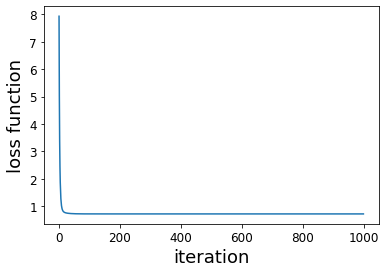

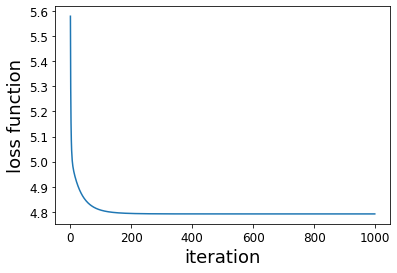

In [10]:
iteration, loss_function_array = gradient_descent(nb_of_iterations = 1000, step_size = 0.1,ridge_parameter = 0.2, add_bias= True)
plt.plot(iteration, loss_function_array)   
plt.xlabel("iteration", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.show()

iteration, loss_function_array = gradient_descent(nb_of_iterations = 1000, step_size = 0.1,ridge_parameter = 0.2, add_bias= False)
plt.plot(iteration, loss_function_array)   
plt.xlabel("iteration", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.show()


From previous results, we can conclude that addings a bias allow to reach more accuracy (loss closer to 0), that seems reasonabale as it is equivalent to adding a constant (and turn a linear function in a affine function). For sake of simplicity, we will stick to the linear model.
For a step size too high (in our case 1), the GD method diverges towards infinity.

Below, we provide convergence rate for various step sizes.

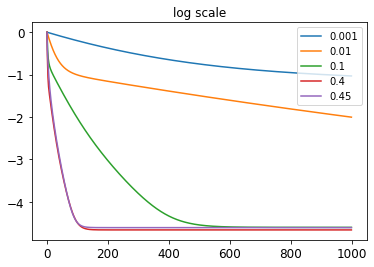

In [25]:
niter = 1000
ridge_parameter = 0.2
flist = np.zeros((niter,1))

step_size_mult = [0.001,0.01,0.1,0.4,0.45]

xopt = np.linalg.solve( A_train.transpose().dot(A_train) + ridge_parameter*np.eye(D), A_train.transpose().dot(Y_train) )
plt.clf

fig, ax  = plt.subplots(1, 1)

for istep in np.arange(0,5):
    step_size = step_size_mult[istep]

    x = np.random.rand(D) #because x takes in account no bias
    for i in np.arange(0,niter):
        flist[i] = (1/N_TRAIN)*np.linalg.norm(np.dot(A_train,x)-Y_train)**2 + (1/N_TRAIN)*ridge_parameter*x.transpose().dot(x)
        grad = (2/N_TRAIN)*A_train.T.dot(np.dot(A_train,x)-Y_train)+(2/N_TRAIN)*ridge_parameter*x
        x = x - step_size*grad
    #plt.subplot(2,1,2)
    e = np.log10( flist - (1/N_TRAIN)*np.linalg.norm(np.dot(A_train,xopt)-Y_train)**2 + (1/N_TRAIN)*ridge_parameter*xopt.transpose().dot(xopt) +1e-20)
    ax.plot(e-e[0], label=str(step_size_mult[istep]))
    ax.axis('tight')
    leg = ax.legend()
    #ax2.legend( str( tau_mult[itau] ) )
    plt.title('log scale')

The empirical optimal step size seems to be around 0.4.

### Question 3: What is the optimal step choice ? How does this compare with the theory ?

From the theory we can compute the optimal step size. It is different from the theoritical one. WHY ? 

In [13]:

#TO DO: CHECK
# doesn't seem to work, don't relate to what we have in practice

C = A_train.T.dot(A_train)
step_size_optimal = 2/(np.linalg.norm(C,2) + np.linalg.norm(C,-2)) # we use a power 2 to get the eigenvalue and not the singular value
print(f"The optimal step size is {step_size_optimal}")


The optimal step size is 6.258541923348254e-05


### Question 4: Show the regression performance on the test set as the ridge penalty changes. 

we keep the same step size, and we will just modify the ridge parameter.

/var/folders/80/bk7d07yj72jcsh655bmmdmmr0000gn/T/ipykernel_41904/1634058331.py:20: RuntimeWarning: invalid value encountered in log10
  e = np.log10( flist - (1/N_TRAIN)*np.linalg.norm(np.dot(A_test,xopt)-Y_test)**2 +1e-20)
/var/folders/80/bk7d07yj72jcsh655bmmdmmr0000gn/T/ipykernel_41904/1634058331.py:20: RuntimeWarning: invalid value encountered in log10
  e = np.log10( flist - (1/N_TRAIN)*np.linalg.norm(np.dot(A_test,xopt)-Y_test)**2 +1e-20)
/var/folders/80/bk7d07yj72jcsh655bmmdmmr0000gn/T/ipykernel_41904/1634058331.py:20: RuntimeWarning: invalid value encountered in log10
  e = np.log10( flist - (1/N_TRAIN)*np.linalg.norm(np.dot(A_test,xopt)-Y_test)**2 +1e-20)
/var/folders/80/bk7d07yj72jcsh655bmmdmmr0000gn/T/ipykernel_41904/1634058331.py:20: RuntimeWarning: invalid value encountered in log10
  e = np.log10( flist - (1/N_TRAIN)*np.linalg.norm(np.dot(A_test,xopt)-Y_test)**2 +1e-20)
/var/folders/80/bk7d07yj72jcsh655bmmdmmr0000gn/T/ipykernel_41904/1634058331.py:20: RuntimeWarning: inval

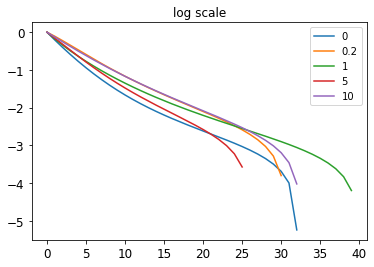

In [31]:
#TO DO: CHECK 
# what to show ? 

niter = 500
step_size = 0.1
flist = np.zeros((niter,1))

ridge_param_mult = [0,0.2,1,5,10]
plt.clf

fig, ax  = plt.subplots(1, 1)

for i_ridge_param in np.arange(0,5):
    ridge_param = ridge_param_mult[i_ridge_param]
    xopt = np.linalg.solve( A_train.transpose().dot(A_train) + ridge_param*np.eye(D), A_train.transpose().dot(Y_train) )
    x = np.random.rand(D) #because x takes in account no bias
    for i in np.arange(0,niter):
        flist[i] = (1/N_TRAIN)*np.linalg.norm(np.dot(A_test,x)-Y_test)**2
        grad = (2/N_TRAIN)*A_train.T.dot(np.dot(A_train,x)-Y_train)+(2/N_TRAIN)*ridge_param*x
        x = x - step_size*grad
    #plt.subplot(2,1,2)
    
    e = np.log10( flist - (1/N_TRAIN)*np.linalg.norm(np.dot(A_test,xopt)-Y_test)**2 +1e-20)
    ax.plot(e-e[0], label=str(ridge_param_mult[i_ridge_param]))
    ax.axis('tight')
    leg = ax.legend()
    #ax2.legend( str( tau_mult[itau] ) )
    plt.title('log scale')
